## ArcticHeat Alamo 11010 Deployment:
** 2018 **


__pyversion__==3.6   
__author__==S.Bell

In [2]:
import datetime
print("Last run {0}".format(datetime.datetime.now()))

Last run 2018-09-17 12:59:13.514881


## ERDDAP Communication and Dataset Retrieval

### Connecting to erddap and retrieving dataset information for ALAMO Floats

In [3]:
import warnings
#remove the numpy/pandas/cython warnings
warnings.filterwarnings(action='ignore', message="numpy.dtype size changed,")

from erddapy import ERDDAP
import pandas as pd
import numpy as np

import cmocean

#server_url='http://downdraft.pmel.noaa.gov:8080/erddap'
server_url='http://ferret.pmel.noaa.gov/alamo/erddap'
e = ERDDAP(server=server_url)

Get only ALAMO Float datafiles - can be found by searching for arctic.

Searching on ALAMO provides an "alldata" response that would need to be filtered out

In [4]:
df = pd.read_csv(e.get_search_url(response='csv', search_for='arctic_heat_alamo_profiles_11010'))

In [5]:
alamos = df['Dataset ID'].values
print(alamos)

['arctic_heat_alamo_profiles_11010']


In [6]:
kw = {
    'standard_name': 'sea_water_temperature',
    'min_lon': -180.0,
    'max_lon': -130.0,
    'min_lat': 65.0,
    'max_lat': 90.0,
    'min_time': '2018-01-10T00:00:00Z',
    'max_time': '2019-01-10T00:00:00Z',
    'cdm_data_type': 'trajectoryprofile'
}

In [7]:
variables = [e.get_var_by_attr(dataset_id=alamo, standard_name=lambda v: v is not None) for alamo in alamos]

common_variables = set(variables[0]).intersection(*variables[1:])

common_variables.update(['CYCLE_NUMBER']) 
#common_variables.remove('JULD')

In [8]:
constraints = {
    'longitude>=': kw['min_lon'],
    'longitude<=': kw['max_lon'],
    'latitude>=': kw['min_lat'],
    'latitude<=': kw['max_lat'],
    'time>=': kw['min_time'],
    'time<=': kw['max_time'],
}

download_url = e.get_download_url(
    dataset_id=alamos[0],
    protocol='tabledap',
    response='csv',
    variables=common_variables,
)

print(download_url)

http://ferret.pmel.noaa.gov/alamo/erddap/tabledap/arctic_heat_alamo_profiles_11010.csv?latitude,CYCLE_NUMBER,time,TEMP,PSAL,longitude,JULD_LOCATION,PRES


### Retrieving Data

In [9]:
from requests.exceptions import HTTPError

dfs = {}
for alamo in alamos:
    print(alamo)
    try:
        e = ERDDAP(server=server_url,
            protocol='tabledap',
            response='csv'
        )
        e.constraints=constraints
        e.variables=common_variables
        e.dataset_id=alamo
    except HTTPError:
        print('Failed to generate url {}'.format(alamo))
        continue
    try:
        dfs.update({alamo: e.to_pandas(
                            index_col='time',
                            parse_dates=True,
                            skiprows=(1,)  # units information can be dropped.
                            )})
    except:
        pass

arctic_heat_alamo_profiles_11010


### Alternative Float Lat/Lon retrievals from WHOI NetCDF files

ERDDAP system is not updating for whatever reasons, pull netcdf files from WHOI system for processing,

In [78]:
#using xarray for data read
import xarray as xa

xdf = xa.open_mfdataset('/Volumes/WDC_internal/Users/bell/ecoraid/2018/Additional_FieldData/ArcticHeat/ALAMO_FLOATS/netcdf_fromWHOI/11010/*.nc')
xdf

<xarray.Dataset>
Dimensions:              (N_LEVELS: 92011, N_PARAM: 3, N_PROF: 1)
Dimensions without coordinates: N_LEVELS, N_PARAM, N_PROF
Data variables:
    PLATFORM_NUMBER      (N_LEVELS, N_PROF) object dask.array<shape=(92011, 1), chunksize=(951, 1)>
    FLOAT_SERIAL_NO      (N_LEVELS, N_PROF) object dask.array<shape=(92011, 1), chunksize=(951, 1)>
    CYCLE_NUMBER         (N_LEVELS, N_PROF) float64 dask.array<shape=(92011, 1), chunksize=(951, 1)>
    STATION_PARAMETERS   (N_LEVELS, N_PROF, N_PARAM) object dask.array<shape=(92011, 1, 3), chunksize=(951, 1, 3)>
    REFERENCE_DATE_TIME  (N_LEVELS) object b'19500101000000' ...
    JULD                 (N_LEVELS, N_PROF) datetime64[ns] dask.array<shape=(92011, 1), chunksize=(951, 1)>
    JULD_LOCATION        (N_LEVELS, N_PROF) datetime64[ns] dask.array<shape=(92011, 1), chunksize=(951, 1)>
    LATITUDE             (N_LEVELS, N_PROF) float64 dask.array<shape=(92011, 1), chunksize=(951, 1)>
    LONGITUDE            (N_LEVELS, N_PROF) f

<xarray.DataArray 'LATITUDE' (N_LEVELS: 92011, N_PROF: 1)>
dask.array<shape=(92011, 1), dtype=float64, chunksize=(951, 1)>
Dimensions without coordinates: N_LEVELS, N_PROF
Attributes:
    axis:           Y
    long_name:      Latitude of the station, best estimate
    standard_name:  latitude
    units:          degree_north
    valid_max:      90.0
    valid_min:      -90.0

### ERDDAP retrieval of Smith and Sandwell Bathymetry (V11.1) for contour

It's easier to just build the url than it is to use erddapy to build it as griddap is not yet officially supported

In [10]:
#using xarray for data read
import xarray as xa

server_url = 'https://coastwatch.pfeg.noaa.gov/erddap/griddap/usgsCeSS111'
bathy = xa.open_dataset(server_url) 

In [11]:
bathy

<xarray.Dataset>
Dimensions:    (latitude: 17280, longitude: 21600)
Coordinates:
  * latitude   (latitude) float32 80.738 80.73531 80.732635 80.72995 ...
  * longitude  (longitude) float32 -179.99167 -179.975 -179.95833 -179.94167 ...
Data variables:
    topo       (latitude, longitude) int16 ...
Attributes:
    cdm_data_type:              Grid
    Conventions:                COARDS, CF-1.6, ACDD-1.3
    creator_email:              jjbecker@ucsd.edu, dsandwell@ucsd.edu
    Easternmost_Easting:        179.9917
    geospatial_lat_max:         80.738
    geospatial_lat_min:         -80.738
    geospatial_lat_units:       degrees_north
    geospatial_lon_max:         179.9917
    geospatial_lon_min:         -179.9917
    geospatial_lon_resolution:  0.016666669753229318
    geospatial_lon_units:       degrees_east
    history:                    28-Apr-2008: Converted to NetCDF using gdal_t...
    infoUrl:                    ftp://topex.ucsd.edu/pub/global_topo_1min
    institution:        

In [43]:
bathy_sub = bathy.sel(latitude=slice(72,70),longitude=slice(-172,-162))

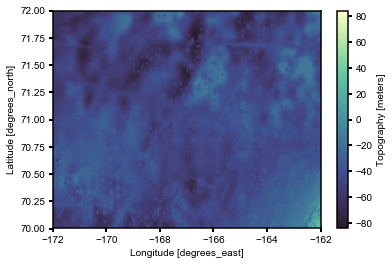

In [44]:
bathy_sub.topo.plot(cmap=cmocean.cm.deep_r)

## Plotting and Visualization

Plots done with matplotlib + cartopy **and** gmt-python 

In [17]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import gmt

### specify primary bulk figure parameters
fontsize = 20
labelsize = 16
#plotstyle = 'seaborn'
max_xticks = 10
plt.style.use('seaborn-ticks')
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['ps.fonttype'] = 42 #truetype/type2 fonts instead of type3
mpl.rcParams['pdf.fonttype'] = 42 #truetype/type2 fonts instead of type3
mpl.rcParams['axes.grid'] = False
mpl.rcParams['axes.edgecolor'] = 'black'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.labelcolor'] = 'black'
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['xtick.major.size'] = 4
mpl.rcParams['xtick.minor.size'] = 1
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['xtick.minor.width'] = 1
mpl.rcParams['ytick.major.size'] = 4
mpl.rcParams['ytick.minor.size'] = 1
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['ytick.minor.width'] = 1
mpl.rcParams['ytick.direction'] = 'out'
mpl.rcParams['xtick.direction'] = 'out'
mpl.rcParams['ytick.color'] = 'black'
mpl.rcParams['xtick.color'] = 'black'

mpl.rcParams['contour.negative_linestyle'] = 'solid'


### WHOI's Quicklook Pages

In [18]:
def show_iframe(src):
    """Helper function to show HTML returns."""
    from IPython.display import HTML
    iframe = '<iframe src="{src}" width="100%" height="950"></iframe>'.format
    return HTML(iframe(src=src))

show_iframe('http://argo.whoi.edu/alamo/11010/index.html')


### Alternative Plots 

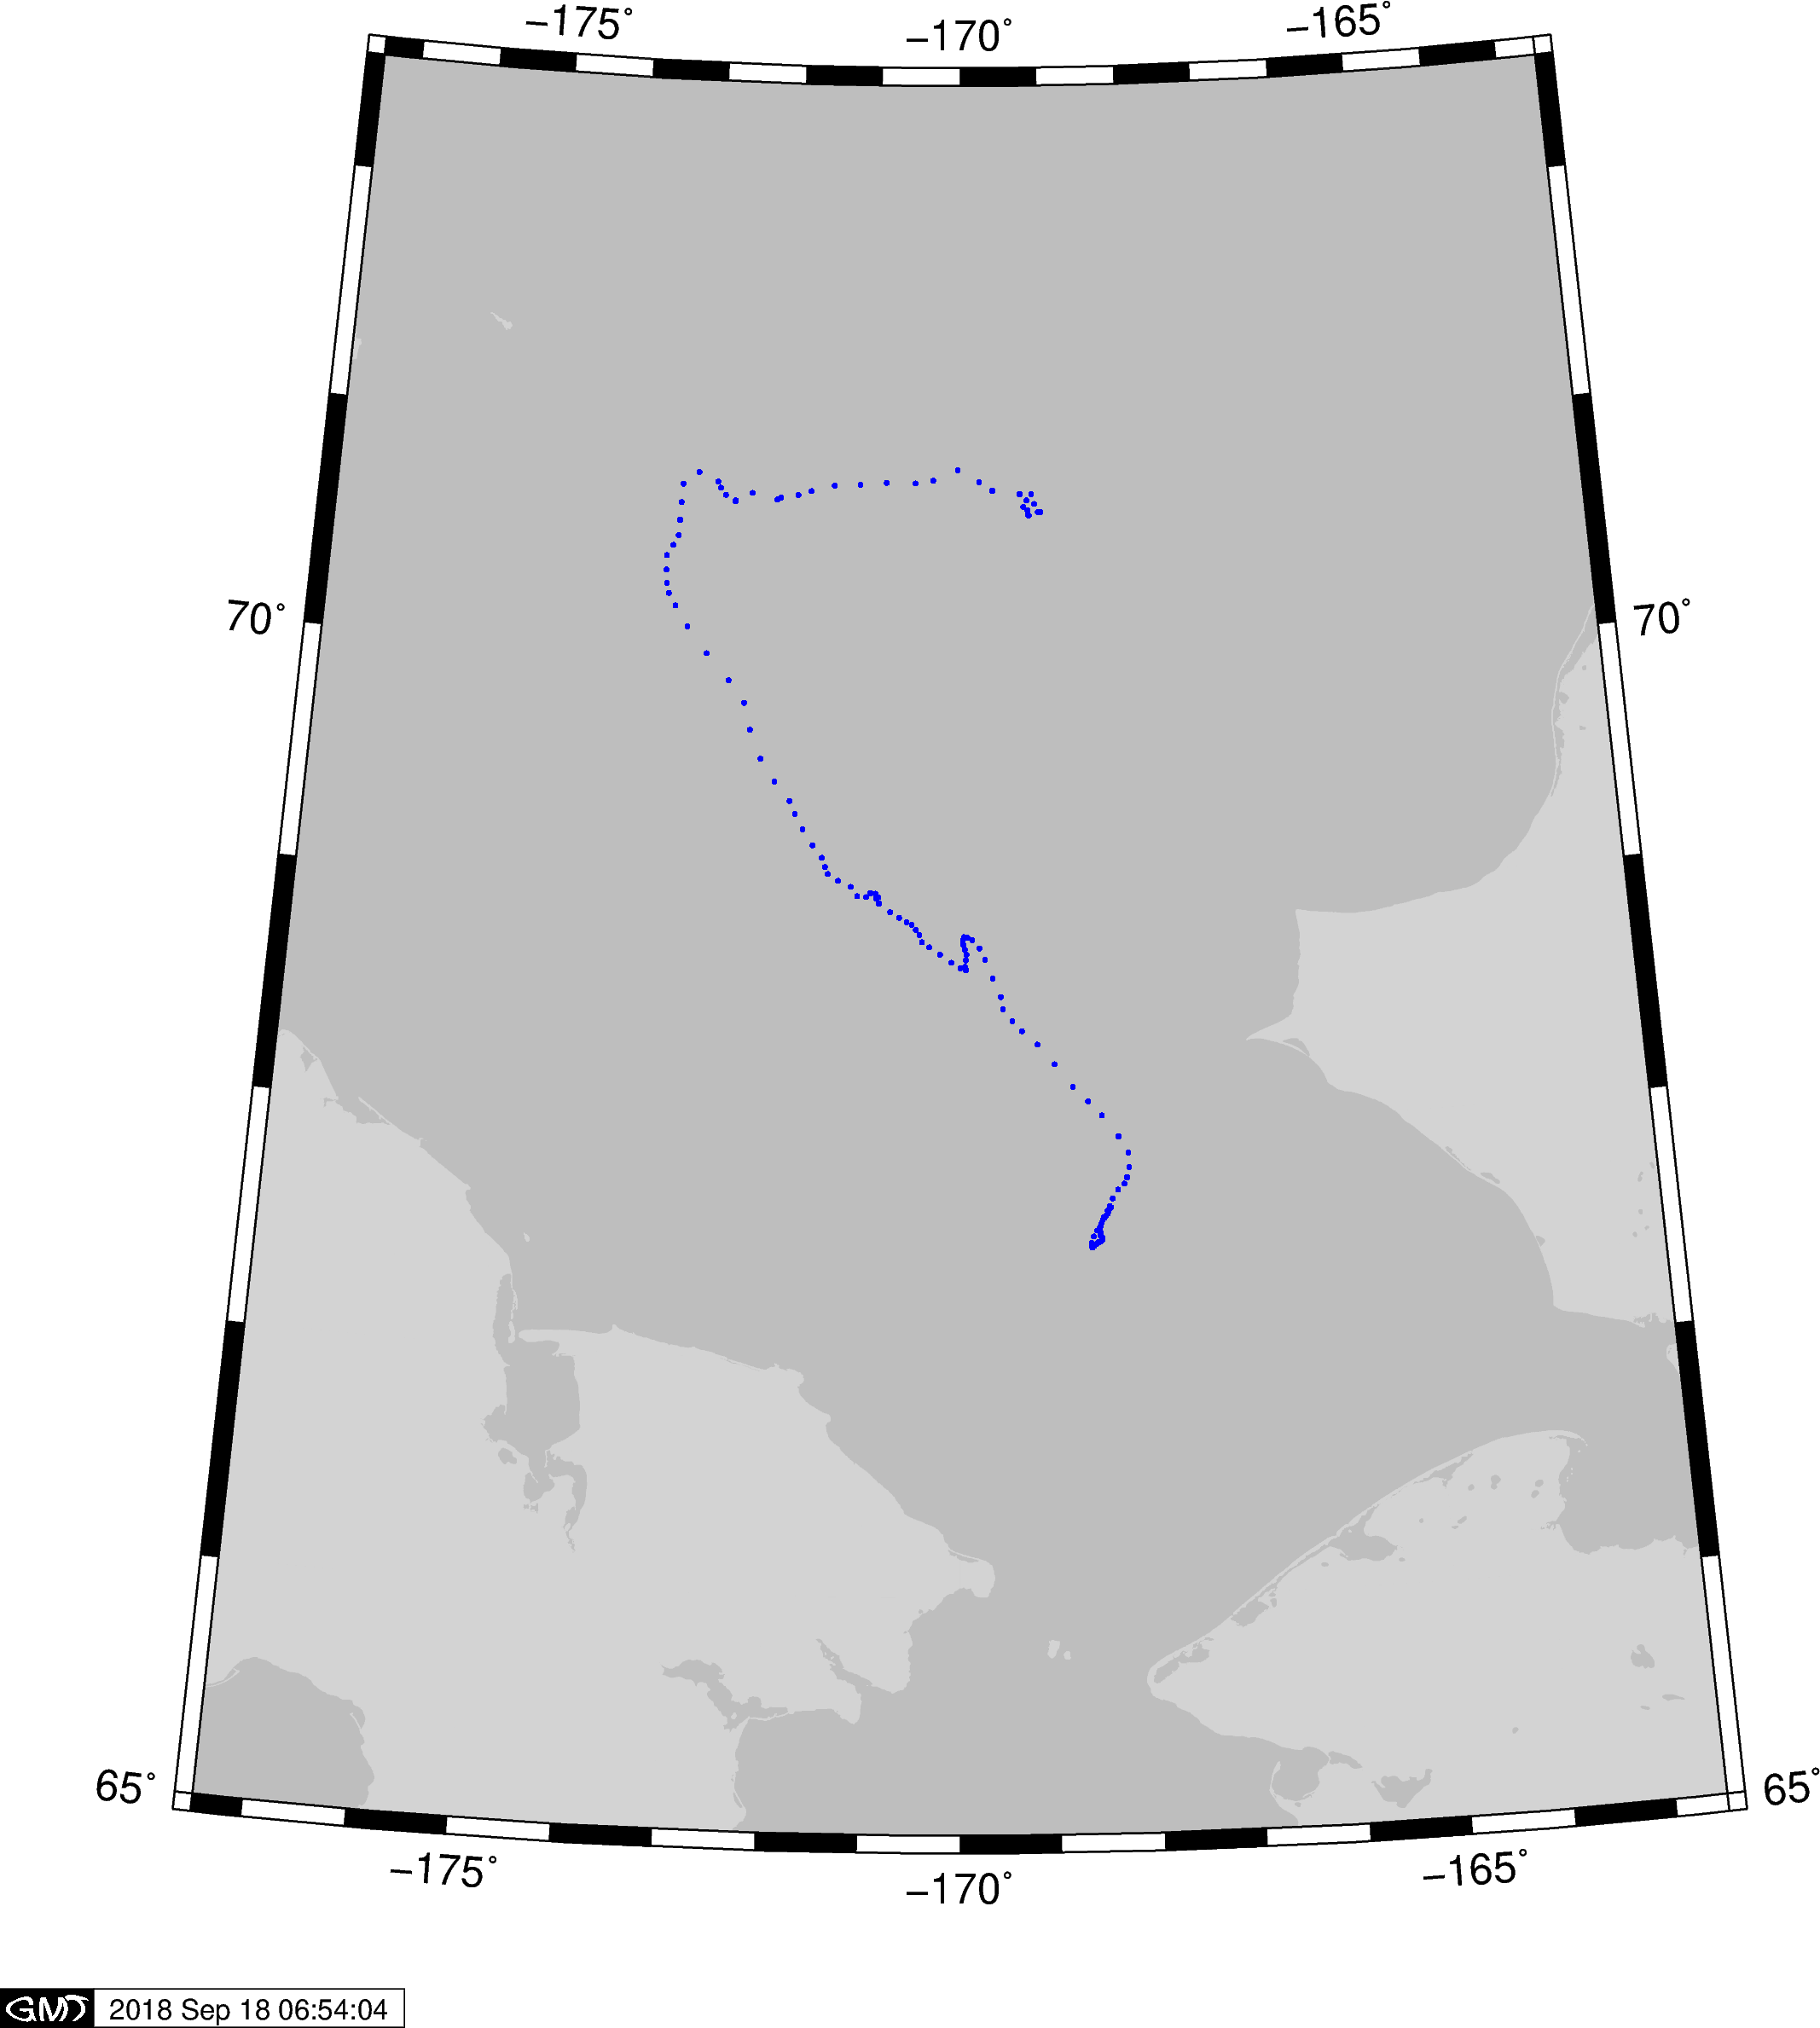

In [75]:
extent = [-177.5, -162.5, 65, 72.5]

fig = gmt.Figure()

fig.coast(region=extent, projection='B-170/60/55/60/6i', land='lightgray', water='gray',
          frame=True,U=True)

for alamo, df in dfs.items():
    fig.plot(x=df['longitude'], y=df['latitude'], color='blue', style='p0.05')


fig.show()

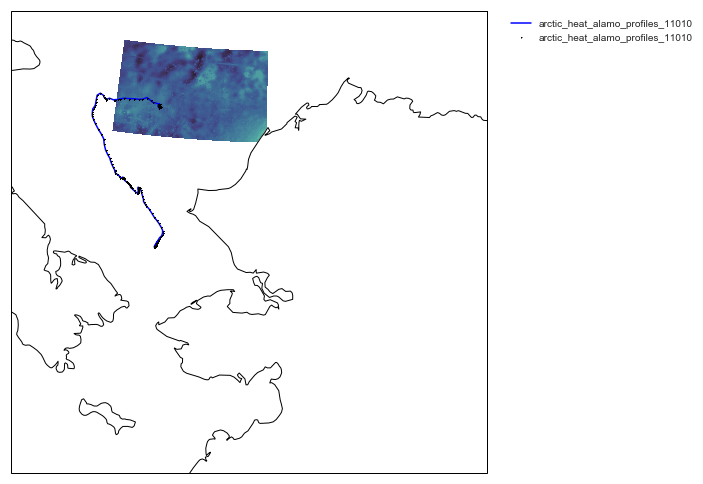

In [53]:
def make_map(projection=ccrs.PlateCarree()):
    fig, ax = plt.subplots(figsize=(16, 8.5),
                           subplot_kw=dict(projection=projection))
    if projection == ccrs.PlateCarree():
        gl = ax.gridlines(draw_labels=True)
        gl.xlabels_top = gl.ylabels_right = False
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
    return fig, ax

projection=ccrs.LambertConformal(central_longitude=-160.0)
transformation=ccrs.PlateCarree()

land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='1.0')

dx = dy = 0.5
extent = [-175, -150, 62, 72.5]
fig,ax = make_map(projection=projection)
for alamo, df in dfs.items():

    ax.plot(df['longitude'], df['latitude'], 'b', label=alamo, transform=transformation)
    ax.plot(df['longitude'], df['latitude'], '+k', markersize=1, label=alamo, transform=transformation)
    ax.pcolormesh(bathy_sub.longitude, bathy_sub.latitude, bathy_sub.topo, cmap=cmocean.cm.deep_r,
             transform=transformation)
#    ax.contour(bathy_sub.longitude, bathy_sub.latitude, bathy_sub.data, [-50,-40,-30], colors='k',
#             transform=transformation)
leg = ax.legend(bbox_to_anchor=(1.45,1), loc='upper right')

ax.add_feature(land_50m)
ax.coastlines(resolution='50m')
ax.set_extent(extent)

### Zoom in on last relative position

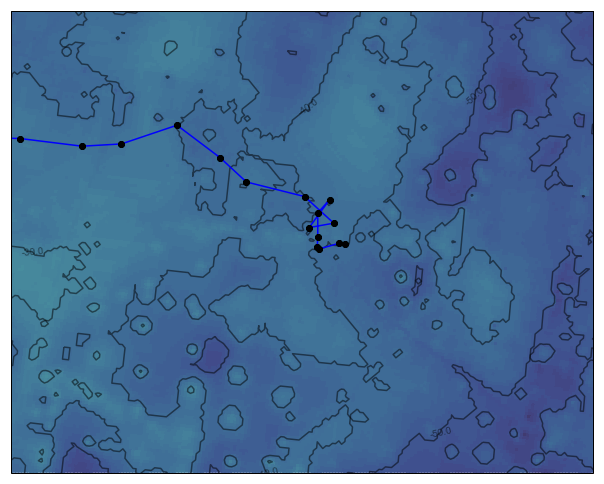

In [73]:
extent = [-170.75, -167.75, 70.25, 71]
fig,ax = make_map(projection=projection)
for alamo, df in dfs.items():

    ax.plot(df['longitude'], df['latitude'], 'b', label=alamo, transform=transformation)
    ax.plot(df['longitude'], df['latitude'], 'ok', markersize=5, label=alamo, transform=transformation)
    ax.pcolormesh(bathy_sub.longitude, bathy_sub.latitude, bathy_sub.topo, cmap=cmocean.cm.deep_r,
             transform=transformation)
    CS = ax.contour(bathy_sub.longitude, bathy_sub.latitude, bathy_sub.topo, levels=[-50, -40, -30], colors='k', alpha=.5,
             transform=transformation)
    ax.clabel(CS, inline=False, fontsize=10, fmt='%1.1f')
#leg = ax.legend(bbox_to_anchor=(1.45,1), loc='upper right')

ax.add_feature(land_50m)
ax.coastlines(resolution='50m')
ax.set_extent(extent)

#fig.savefig('map.png',bbox_inches='tight',dpi=300)

## Zoom in on last Relative Positon - using WHOI raw data

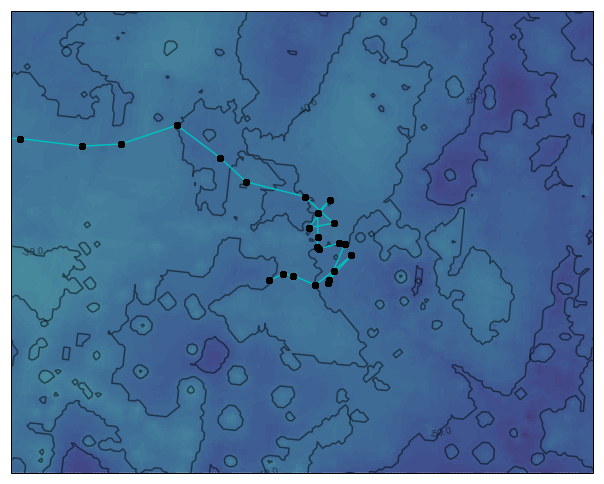

In [84]:
extent = [-170.75, -167.75, 70.25, 71]
fig,ax = make_map(projection=projection)

ax.plot(xdf['LONGITUDE'], xdf['LATITUDE'], 'c', transform=transformation)
ax.plot(xdf['LONGITUDE'], xdf['LATITUDE'], 'ok', markersize=5, transform=transformation)
ax.pcolormesh(bathy_sub.longitude, bathy_sub.latitude, bathy_sub.topo, cmap=cmocean.cm.deep_r,
         transform=transformation)
CS = ax.contour(bathy_sub.longitude, bathy_sub.latitude, bathy_sub.topo, levels=[-50, -40, -30], colors='k', alpha=.5,
         transform=transformation)
ax.clabel(CS, inline=False, fontsize=10, fmt='%1.1f')
#leg = ax.legend(bbox_to_anchor=(1.45,1), loc='upper right')

ax.add_feature(land_50m)
ax.coastlines(resolution='50m')
ax.set_extent(extent)

fig.savefig('map.png',bbox_inches='tight',dpi=300)

## Depth v Time/Dive Profiles

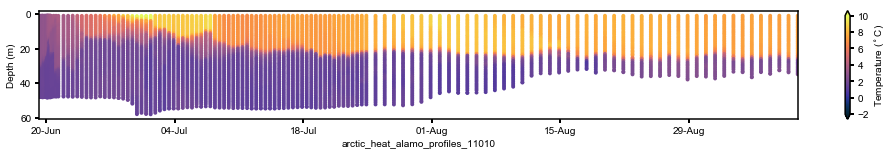

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import cmocean

for dfn, df in dfs.items():
    fig, ax = plt.subplots(figsize=(17, 2))
    cs = ax.scatter(df.index, df['PRES'], s=15, c=df['TEMP'], marker='o', edgecolor='none', vmin=-2, vmax=10, cmap=cmocean.cm.thermal)

    ax.invert_yaxis()
    ax.set_xlim(df.index[0], df.index[-1])
    xfmt = mdates.DateFormatter('%d-%b')
    ax.xaxis.set_major_formatter(xfmt)

    cbar = fig.colorbar(cs, orientation='vertical', extend='both')
    cbar.ax.set_ylabel('Temperature ($^\circ$C)')
    ax.set_ylabel('Depth (m)')
    ax.set_xlabel(dfn)

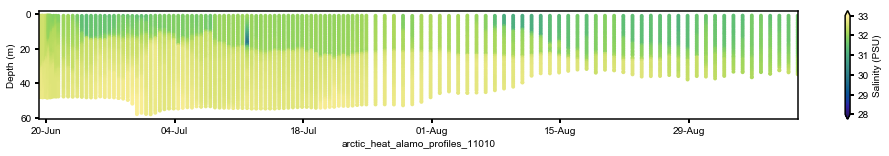

In [24]:
for dfn, df in dfs.items():
    fig, ax = plt.subplots(figsize=(17, 2))
    cs = ax.scatter(df.index, df['PRES'], s=15, c=df['PSAL'], marker='o', edgecolor='none', vmin=28, vmax=33,cmap=cmocean.cm.haline)

    ax.invert_yaxis()
    ax.set_xlim(df.index[0], df.index[-1])
    xfmt = mdates.DateFormatter('%d-%b')
    ax.xaxis.set_major_formatter(xfmt)

    cbar = fig.colorbar(cs, orientation='vertical', extend='both')
    cbar.ax.set_ylabel('Salinity (PSU)')
    ax.set_ylabel('Depth (m)')
    ax.set_xlabel(dfn)

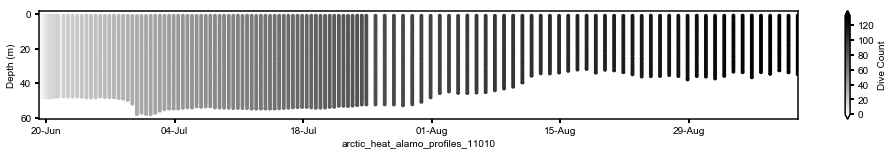

In [25]:
for dfn, df in dfs.items():
    fig, ax = plt.subplots(figsize=(17, 2))
    cs = ax.scatter(df.index, df['PRES'], s=15, c=df['CYCLE_NUMBER'], marker='o', edgecolor='none',cmap=cmocean.cm.gray_r)

    ax.invert_yaxis()
    ax.set_xlim(df.index[0], df.index[-1])
    xfmt = mdates.DateFormatter('%d-%b')
    ax.xaxis.set_major_formatter(xfmt)

    cbar = fig.colorbar(cs, orientation='vertical', extend='both')
    cbar.ax.set_ylabel('Dive Count')
    ax.set_ylabel('Depth (m)')
    ax.set_xlabel(dfn)

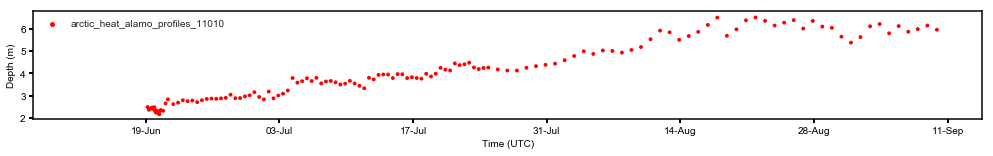

In [26]:
#depth averaged temp - interpolate to 1m bins before averaging
colors = ['r','y','k','b','g','c','olive','lightblue','grey']
ccount=0
legend_label=[]

fig, ax = plt.subplots(figsize=(17, 2))
for dfn, df in dfs.items():
    fg = df.groupby('CYCLE_NUMBER')

    for ind,fgi in enumerate(fg.groups):
        IntTemp = np.interp(np.arange(0,50,1),fg.get_group(fgi)['PRES'], fg.get_group(fgi)['TEMP'], left=np.nan, right=np.nan)
        cs = ax.scatter(fg.get_group(fgi).index[0], np.nanmean(IntTemp), s=15, c=colors[ccount], marker='o', edgecolor='none')

    xfmt = mdates.DateFormatter('%d-%b')
    ax.xaxis.set_major_formatter(xfmt)

    ax.set_ylabel('Depth (m)')
    ax.set_xlabel('Time (UTC)')
    ccount+=1
    
    legend_label.append(dfn)

ax.legend(legend_label)
leg = ax.get_legend()
for i in range(0,len(legend_label),1):
    leg.legendHandles[i].set_color(colors[i])
